### We will compare different methods

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
epochs_per_batch = 100

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=500000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all[df_all['time'] <= epochs_per_batch * time_epoch]

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [2]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all[df_all['time'] <= epochs_per_batch * time_epoch * 2]['source computer'].values))) 

In [3]:
from helper import group_scale_data, group_scale_data_batch

groupped_data, hosts, parameters = group_scale_data(df, size_of_bin_seconds=time_epoch,
                                                    addZeros=True, doScale=True, scaler='log', hosts=hosts)

In [4]:
print('Total number of hosts:', len(hosts))
print('Total datapoints:', len(groupped_data))

Total number of hosts: 1912
Total datapoints: 191200


# First method used will be a simple kmeans on the whole dataset 

Lets denote N the number of hosts, M the number of epochs. This will give us an NxM dataset with 2 points vector

We simply cluster this points together 

In [5]:
from sklearn.cluster import KMeans
import numpy as np

number_of_clusters = 15

all_raw_data = groupped_data.values[:,:2]

kmeans_whole_data = KMeans(n_clusters=number_of_clusters, random_state=0).fit(all_raw_data)

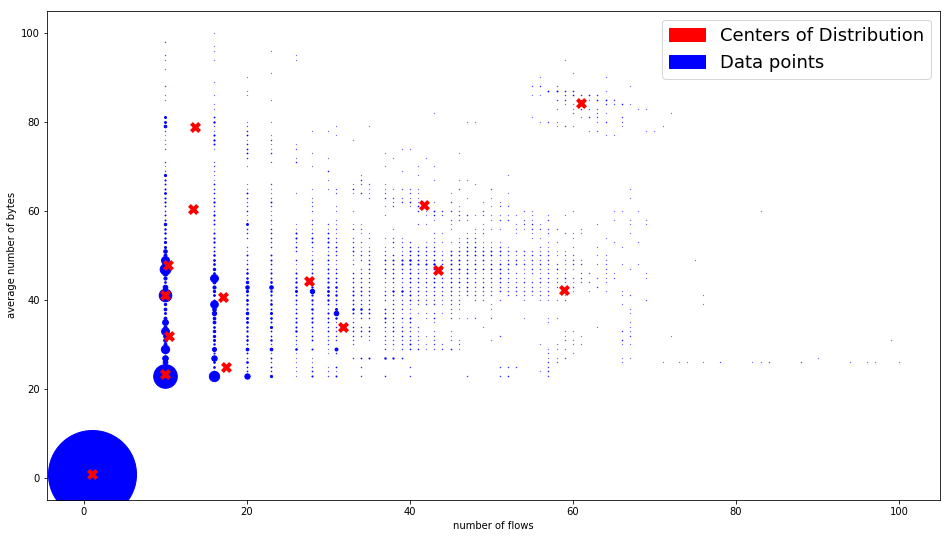

In [6]:
from plots import plot_points

# Hack in order to display the plot
kmeans_whole_data.lambdas = kmeans_whole_data.cluster_centers_

num_clusters = len(kmeans_whole_data.cluster_centers_)
kmeans_whole_data.gammas = [1/num_clusters] * num_clusters

plot_points(all_raw_data, kmeans_whole_data)

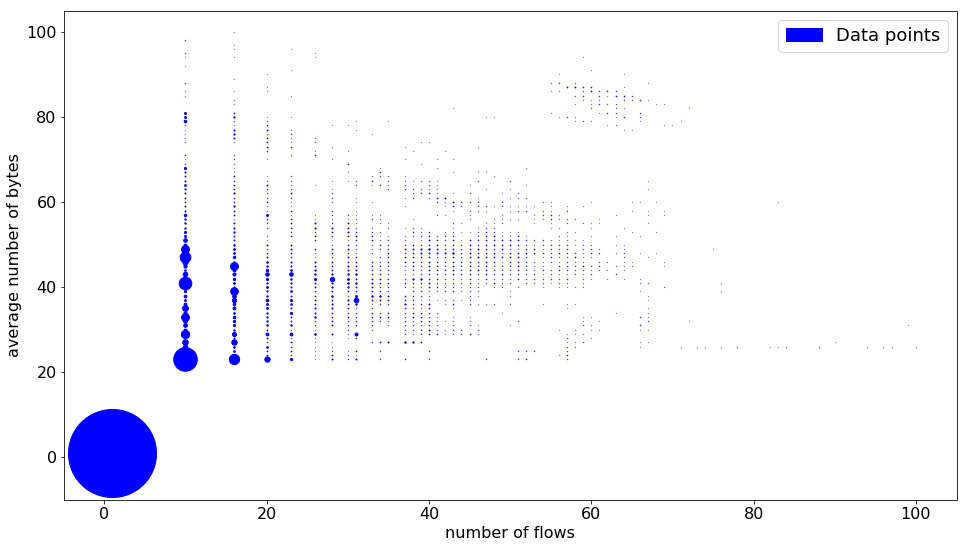

In [35]:
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']


def plot_points(data, em=None):
    rcParams['figure.figsize'] = 16, 9
    rcParams['font.size'] = 16
    data_hashable = [tuple(x) for x in data]
    total_points = len(data_hashable)

    values = np.vstack([list(x) for x in list(Counter(data_hashable).keys())])
    counts = np.array(list(Counter(data_hashable).values()))

    for i in range(len(values)):
        plt.scatter(values[i][0], values[i][1], s=counts[i]*10000/total_points, color='blue')
        
    if em:
        for i, lambda_i in enumerate(em.lambdas):
            plt.scatter(lambda_i[0], lambda_i[1], s=em.gammas[i]*1000, linewidth=4, color='red', marker='x')

        blue_patch = mpatches.Patch(color='blue', label='Data points')
        red_patch = mpatches.Patch(color='red', label='Centers of Distribution')
        plt.legend(handles=[red_patch, blue_patch], fontsize=18)
    else:
        blue_patch = mpatches.Patch(color='blue', label='Data points')
        plt.legend(handles=[blue_patch], fontsize=18)
    
    plt.ylabel('average number of bytes')
    plt.xlabel('number of flows')
    plt.xlim([-5,105])
    plt.ylim([-10,105])
    plt.show()
    
plot_points(all_raw_data)

### Next we will use an average on each host

That will generate N vectors of 2 points for the 2 features 

In [7]:
groupped_data.groupby('source computer').mean().head()

,number of flows,mean(byte count),epoch
source computer,,,
C10,1.45,2.10,50.5
C100,7.03,12.66,50.5
C1000,2.62,6.84,50.5
C1001,7.83,12.30,50.5
C1002,4.24,8.92,50.5


### Lets see the average for each host with and without the zeros

Most hosts have almost zero traffic by average

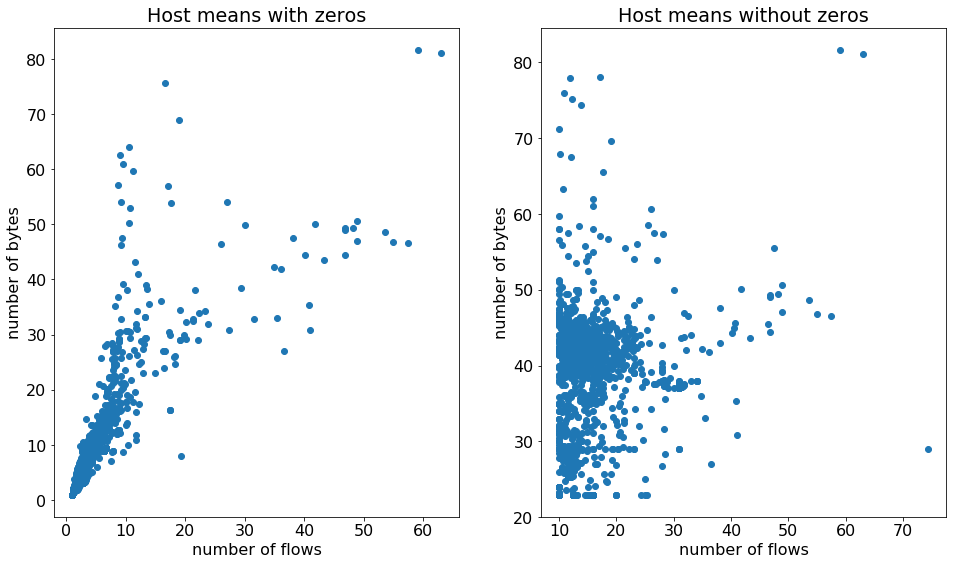

In [36]:
import matplotlib.pyplot as plt


rcParams['font.size'] = 16


host_raw_data = groupped_data.groupby('source computer').mean().values[:,:2]
host_raw_data_no_zeros = groupped_data[groupped_data['number of flows'] > 1].groupby('source computer').mean().values[:,:2]

plt.subplot(1,2,1)
plt.title('Host means with zeros')
plt.ylabel('number of bytes')
plt.xlabel('number of flows')
plt.scatter(host_raw_data[:,0], host_raw_data[:,1])

plt.subplot(1,2,2)
plt.title('Host means without zeros')
plt.ylabel('number of bytes')
plt.xlabel('number of flows')
plt.scatter(host_raw_data_no_zeros[:,0], host_raw_data_no_zeros[:,1])
plt.show()

In [9]:
from sklearn.cluster import KMeans
import numpy as np

number_of_clusters = 15

host_raw_data = groupped_data.groupby('source computer').mean().values[:,:2]

kmeans_host_data = KMeans(n_clusters=number_of_clusters, random_state=0).fit(host_raw_data)

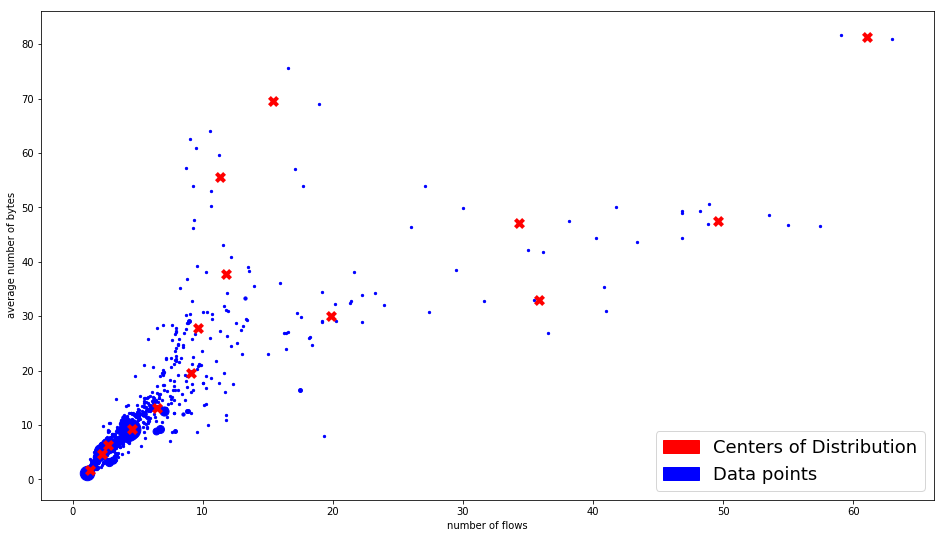

In [10]:
kmeans_host_data.lambdas = kmeans_host_data.cluster_centers_

num_clusters = len(kmeans_host_data.cluster_centers_)
kmeans_host_data.gammas = [1/num_clusters] * num_clusters

plot_points(host_raw_data, kmeans_host_data)

### Next we will use an average on each epoch
That will generate M vectors of 2 points for the 2 features

In [11]:
groupped_data.groupby('epoch').mean().head()

,number of flows,mean(byte count)
epoch,,
1,3.653243,7.591004
2,5.277720,10.564331
3,3.817992,7.851464
4,3.730649,7.799163
5,5.252092,11.057531


### Lets see the average for each epoch with and without the zeros

if we ignore zeros averages are much closer together so the epoch means do not really change

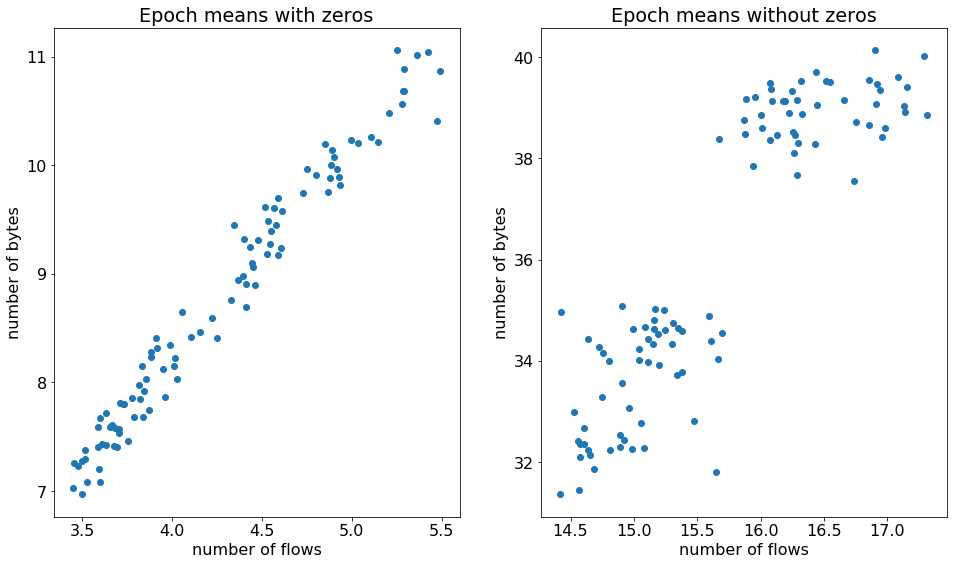

In [37]:
import matplotlib.pyplot as plt

epoch_raw_data = groupped_data.groupby('epoch').mean().values[:,:2]
epoch_raw_data_no_zeros = groupped_data[groupped_data['number of flows'] > 1].groupby('epoch').mean().values[:,:2]

plt.subplot(1,2,1)
plt.title('Epoch means with zeros')
plt.ylabel('number of bytes')
plt.xlabel('number of flows')
plt.scatter(epoch_raw_data[:,0], epoch_raw_data[:,1])

plt.subplot(1,2,2)
plt.title('Epoch means without zeros')
plt.ylabel('number of bytes')
plt.xlabel('number of flows')
plt.scatter(epoch_raw_data_no_zeros[:,0], epoch_raw_data_no_zeros[:,1])
plt.show()

In [13]:
from sklearn.cluster import KMeans
import numpy as np

number_of_clusters = 15

epoch_raw_data = groupped_data.groupby('epoch').mean().values[:,:2]

kmeans_epoch_data = KMeans(n_clusters=number_of_clusters, random_state=0).fit(epoch_raw_data)

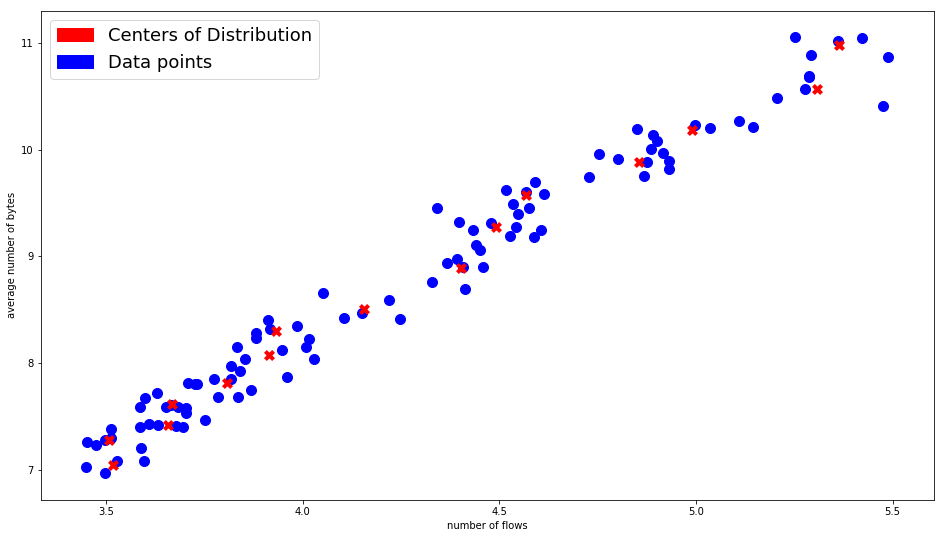

In [14]:
kmeans_epoch_data.lambdas = kmeans_epoch_data.cluster_centers_

num_clusters = len(kmeans_epoch_data.cluster_centers_)
kmeans_epoch_data.gammas = [1/num_clusters] * num_clusters

plot_points(epoch_raw_data, kmeans_epoch_data)

### Now we will test how well they can score new datapoints

In [15]:
# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=500000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all[(df_all['time'] > epochs_per_batch * time_epoch) & (df_all['time'] <= epochs_per_batch * time_epoch * 2)]

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
6001,0,C1514,123,C625,123,17,1,96
6001,0,C1543,N603,C586,389,17,1,193
6001,0,C1685,N7,C6482,N2481,6,4,445
6001,0,C1685,N7,C6482,N2482,6,6,5055
6001,0,C17,N177,C1883,445,6,1,52


In [107]:
# scale the data using the same scaler

groupped_data_test, _ = group_scale_data_batch(df, parameters)
groupped_data_test['epoch'] += epochs_per_batch

In [108]:
from scipy.spatial.distance import euclidean

def calculate_error(algorithm, data):
    num_points = len(data)
    
    assert num_points > 0
    
    
    total_error = 0
    
    if isinstance(algorithm, KMeans):
        predictions = algorithm.predict(data)
        for data_i, prediction_i in zip(data, predictions):
            distance_to_closest_center = euclidean(data_i, algorithm.cluster_centers_[prediction_i])
            total_error += pow(distance_to_closest_center, 2)
        
    return total_error/num_points

### First method: Calculate its data point seperately

In [109]:
print('These results correspond to average the average distance from each individual cluster point seperately')
print('This may be unwise for the clustering done for each individual host and epoch')
print()

print('Error from whole kmeans clustering', calculate_error(kmeans_whole_data, groupped_data_test.values[:, :2]))
print('Error from host kmeans clustering individual data points', calculate_error(kmeans_host_data, groupped_data_test.values[:, :2]))
print('Error from epoch kmeans clustering individual data points', calculate_error(kmeans_epoch_data, groupped_data_test.values[:, :2]))

These results correspond to average the average distance from each individual cluster point seperately
This may be unwise for the clustering done for each individual host and epoch

Error from whole kmeans clustering 2.92962231266
Error from host kmeans clustering individual data points 9.07376323409
Error from epoch kmeans clustering individual data points 253.977028044


In [110]:
print('The following scores correspond after the grouping by')
print()

print('Error from host kmeans after group by', 
      calculate_error(kmeans_host_data, groupped_data_test.groupby('source computer').mean().values[:,:2]))
print('Error from epoch kmeans after group by', 
      calculate_error(kmeans_epoch_data, groupped_data_test.groupby('epoch').mean().values[:,:2]))

The following scores correspond after the grouping by

Error from host kmeans after group by 3.108010425008985
Error from epoch kmeans after group by 0.02206945195645646


### Finally distance scores based on each host past 

In [111]:
train_data = groupped_data.groupby('source computer').mean()
train_data.drop(columns=['epoch'],inplace=True)
print(train_data.head())

test_data = groupped_data_test.groupby('source computer').mean()
test_data.drop(columns=['epoch'],inplace=True)
print(test_data.head())

                 number of flows  mean(byte count)
source computer                                   
C10                         1.45              2.10
C100                        7.03             12.66
C1000                       2.62              6.84
C1001                       7.83             12.30
C1002                       4.24              8.92
                 number of flows  mean(byte count)
source computer                                   
C10                         1.45              2.10
C100                        6.97             13.10
C1000                       2.62              6.48
C1001                       7.62             11.32
C1002                       4.15              8.70


In [112]:
def calculate_error_by_host(train, test):
    num_points = 0
    
    total_error = 0
    
    for index, row in test.iterrows():
        if index in train.index:
            distance_to_closest_center = euclidean(row.values, train.loc[index].values)
            total_error += pow(distance_to_closest_center, 2)
            num_points += 1
        
    return total_error/num_points

In [113]:
calculate_error_by_host(train_data, test_data)

5.573166841004201

In [114]:
test_data_by_host = groupped_data_test.copy()
test_data_by_host.index = test_data_by_host['source computer']
test_data_by_host.drop(columns=['epoch'],inplace=True)
test_data_by_host.drop(columns=['source computer'],inplace=True)


calculate_error_by_host(train_data, test_data_by_host)

201.481193985323

In [115]:
# 

number_of_points = range(10, epochs_per_batch, 10)
for points in number_of_points:
    host_count = groupped_data[groupped_data['number of flows'] > 1].groupby('source computer').count()
    hosts_with_at_least_N_points = host_count[host_count['epoch'] > points].index.values

    data_for_host_with_lots_of_traffic = groupped_data[groupped_data['source computer'].isin(hosts_with_at_least_N_points)]
    
    train_data = data_for_host_with_lots_of_traffic.groupby('source computer').mean()
    train_data.drop(columns=['epoch'],inplace=True)
    
    print(points, calculate_error_by_host(train_data, test_data))
    print(points, calculate_error_by_host(train_data, test_data_by_host))

10 4.296269036334904
10 231.04849494464435
20 4.34103107890501
20 242.53839645731327
30 4.387796819085501
30 216.13443677931932
40 2.1611752767527657
40 240.51540553505353
50 1.9575657276995302
50 228.4320441314576
60 2.498726490066225
60 213.30825695364163
70 2.9684499999999994
70 187.70480932203122
80 2.4271067415730325
80 153.79107752808903
90 2.4334405797101435
90 99.99244057971


In [138]:
# MSE WITHIN THE SAME EPOCH 

mses = 0
num_epochs = 0

for epoch in range(1, epochs_per_batch + 1):
    dd = groupped_data[groupped_data['epoch'] == epoch]
    
    mse = 0
    num_points = 0
    
    center = dd.mean().values[:2]
    for point in dd.values[:, :2]:
        mse += pow(euclidean(point, center), 2)
        num_points += 1
    
    mses += mse/num_points
    num_epochs += 1
    
mses = mses / num_epochs
print(mses)
print(num_epochs)

297.680729315
100


### What is the difference between onlineEM with and without the different profile groups?

In [23]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories

In [24]:
from kplusplus import KPlusPlus


kplusplus = KPlusPlus(number_of_clusters, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=3000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7
Centers found: 8
Centers found: 9
Centers found: 10
Centers found: 11
Centers found: 12
Centers found: 13
Centers found: 14
Centers found: 15


In [25]:
kplusplus.centers

[array([1, 1], dtype=object),
 array([70, 78], dtype=object),
 array([10, 25], dtype=object),
 array([10, 81], dtype=object),
 array([45, 29], dtype=object),
 array([20, 50], dtype=object),
 array([40, 62], dtype=object),
 array([20, 31], dtype=object),
 array([10, 42], dtype=object),
 array([51, 52], dtype=object),
 array([16, 76], dtype=object),
 array([16, 39], dtype=object),
 array([33, 38], dtype=object),
 array([10, 35], dtype=object),
 array([16, 23], dtype=object)]

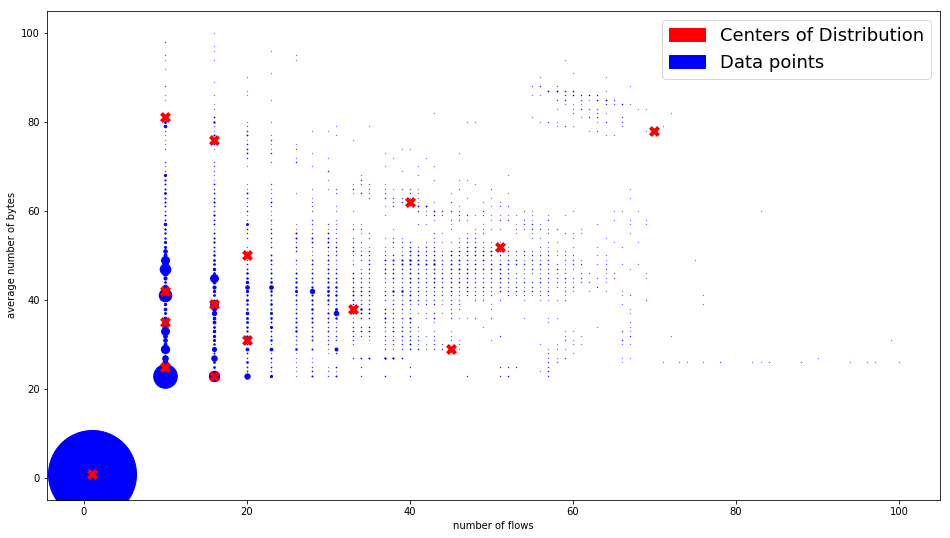

In [26]:
# random initialization
onlineEM = OnlineEM([1/number_of_clusters]*number_of_clusters, kplusplus.centers, 500, n_clusters=8, verbose=1)
plot_points(groupped_data.values[:,:2], em=onlineEM)

In [27]:
data = groupped_data.values[:,[0,1,3]]
np.random.shuffle(data)
onlineEM.fit(data)

Running for data till position 500 from total 191200
Running for data till position 1000 from total 191200
Running for data till position 1500 from total 191200
Running for data till position 2000 from total 191200
Running for data till position 2500 from total 191200
Running for data till position 3000 from total 191200
Running for data till position 3500 from total 191200
Running for data till position 4000 from total 191200
Running for data till position 4500 from total 191200
Running for data till position 5000 from total 191200
Running for data till position 5500 from total 191200
Running for data till position 6000 from total 191200
Running for data till position 6500 from total 191200
Running for data till position 7000 from total 191200
Running for data till position 7500 from total 191200
Running for data till position 8000 from total 191200
Running for data till position 8500 from total 191200
Running for data till position 9000 from total 191200
Running for data till positio

Running for data till position 75500 from total 191200
Running for data till position 76000 from total 191200
Running for data till position 76500 from total 191200
Running for data till position 77000 from total 191200
Running for data till position 77500 from total 191200
Running for data till position 78000 from total 191200
Running for data till position 78500 from total 191200
Running for data till position 79000 from total 191200
Running for data till position 79500 from total 191200
Running for data till position 80000 from total 191200
Running for data till position 80500 from total 191200
Running for data till position 81000 from total 191200
Running for data till position 81500 from total 191200
Running for data till position 82000 from total 191200
Running for data till position 82500 from total 191200
Running for data till position 83000 from total 191200
Running for data till position 83500 from total 191200
Running for data till position 84000 from total 191200
Running fo

Running for data till position 149500 from total 191200
Running for data till position 150000 from total 191200
Running for data till position 150500 from total 191200
Running for data till position 151000 from total 191200
Running for data till position 151500 from total 191200
Running for data till position 152000 from total 191200
Running for data till position 152500 from total 191200
Running for data till position 153000 from total 191200
Running for data till position 153500 from total 191200
Running for data till position 154000 from total 191200
Running for data till position 154500 from total 191200
Running for data till position 155000 from total 191200
Running for data till position 155500 from total 191200
Running for data till position 156000 from total 191200
Running for data till position 156500 from total 191200
Running for data till position 157000 from total 191200
Running for data till position 157500 from total 191200
Running for data till position 158000 from total

### These are the centers after the fitting

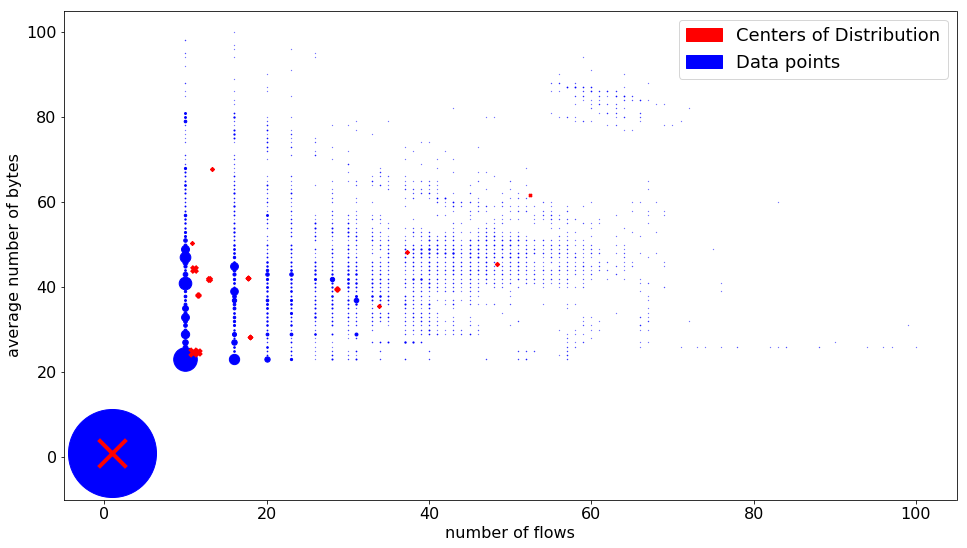

In [139]:
plot_points(groupped_data.values[:,:2], em=onlineEM)

### Next we will test what is the log likelihood with and without the use of group profiling 

We will use as test data the next 50 epochs

In [29]:
df1 = df_all[(df_all['time'] > epochs_per_batch * time_epoch) & (df_all['time'] <= epochs_per_batch * time_epoch * 2)]

df1.index = df1['time']
df1.drop(columns=['time'], inplace=True)
df1.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
6001,0,C1514,123,C625,123,17,1,96
6001,0,C1543,N603,C586,389,17,1,193
6001,0,C1685,N7,C6482,N2481,6,4,445
6001,0,C1685,N7,C6482,N2482,6,6,5055
6001,0,C17,N177,C1883,445,6,1,52


In [30]:
groupped_data_test, _ = group_scale_data_batch(df1, parameters)
groupped_data_test['epoch'] += epochs_per_batch

assert len(groupped_data) == len(groupped_data_test)
groupped_data_test.head()

,number of flows,mean(byte count),epoch,source computer
0,35,27,101,C1015
65290,1,1,101,C2291
151859,1,1,101,C4405
86787,1,1,101,C3890
65200,1,1,101,C286


In [31]:
import scipy.stats.distributions
from math import log

def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

# log likelihoods with and without clusters
def likelihoods(em, data):
    total_likelihood = 0
    total_likelihood_clusters = 0
    
    n = 0
    for x_i in data:
        host = x_i[-1]
        if host in em.hosts:
            x = x_i[:-1]

            participations = np.array([poisson(x, lambda_i) for lambda_i in em.lambdas])

            total_likelihood = total_likelihood + log(np.sum(em.gammas * participations))

            total_likelihood_clusters = total_likelihood_clusters + log(np.sum(em.probabilities_per_kMean_cluster[em.hosts[host]['category']] * participations))
            
            n += 1
        
    no_clusters = total_likelihood / n
    with_clusters = total_likelihood_clusters / n
    percentage_change = (with_clusters - no_clusters)*100 / no_clusters 
    return no_clusters, with_clusters, percentage_change

print('whole data', likelihoods(onlineEM, groupped_data_test.values[:,[0,1,3]]))

whole data (-3.6337389049183577, -3.391677671597683, -6.661492189024336)


### The difference may be bigger for host we have more information about

In [32]:
number_of_points = range(10, epochs_per_batch, 10)
for points in number_of_points:
    host_count = groupped_data[groupped_data['number of flows'] > 1].groupby('source computer').count()
    hosts_with_at_least_N_points = host_count[host_count['epoch'] > points].index.values

    data_for_host_with_lots_of_traffic = groupped_data_test[groupped_data_test['source computer'].isin(hosts_with_at_least_N_points)]

    print('Hosts with at least', points, 'points in the train data', likelihoods(onlineEM, data_for_host_with_lots_of_traffic.values[:,[0,1,3]]))

Hosts with at least 10 points in the train data (-4.090804627576107, -3.7754737175801303, -7.708285745800021)
Hosts with at least 20 points in the train data (-5.193464837612716, -4.615860865464249, -11.121746082986366)
Hosts with at least 30 points in the train data (-5.528976489771504, -4.820956441940193, -12.80562594435217)
Hosts with at least 40 points in the train data (-6.741042750834926, -5.646907491467307, -16.230949718158993)
Hosts with at least 50 points in the train data (-7.286680580169902, -5.959712092991096, -18.21087767714205)
Hosts with at least 60 points in the train data (-8.091380270330397, -6.3812621227479465, -21.135060897497787)
Hosts with at least 70 points in the train data (-8.696028025524715, -6.6515164447197, -23.51086697057476)
Hosts with at least 80 points in the train data (-9.270521837382708, -6.917304583105807, -25.383870461182916)
Hosts with at least 90 points in the train data (-9.659002637586966, -7.117016447891133, -26.31727399891132)
